# Model Visualization Notebook

This notebook loads a PyTorch dataset saved as `.pt`, initializes your model, and generates a schematic graph using **torchview**.

In [16]:
import os
import torch
from importlib import import_module

# ---- User inputs (EDIT ME) ----
DATASET_PT_PATH = "/workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/gru/multiple_hosp_patients/test_dataset.pt"  # path to your .pt file
MODEL_MODULE = "recurrent_health_events_prediction.model.RecurrentHealthEventsDL"
MODEL_CLASS_NAME = "GRUNet"   # e.g., GRUNet, AttentionPoolingNet, CrossAttnPoolingNet
CONFIG_PATH = "/workspaces/msc-thesis-recurrent-health-modeling/_runs/gru_20251019_124144/model_config.yaml"  # e.g., "configs/cross_attn.yaml" or keep None and fill MODEL_PARAMS below

In [17]:
# Optional: load YAML config if provided
if CONFIG_PATH is not None:
    import yaml
    with open(CONFIG_PATH, "r") as f:
        cfg = yaml.safe_load(f)
    MODEL_CLASS_NAME = cfg.get("model_class", MODEL_CLASS_NAME)
    MODEL_PARAMS = cfg.get("model_params")
    print("Loaded config:", CONFIG_PATH)
else:
    print("Using inline MODEL_PARAMS.")
print("Model class:", MODEL_CLASS_NAME)
print("Model params:", MODEL_PARAMS)


Loaded config: /workspaces/msc-thesis-recurrent-health-modeling/_runs/gru_20251019_124144/model_config.yaml
Model class: GRUNet
Model params: {'dropout': 0.014144619706414313, 'hidden_size_head': 64, 'hidden_size_seq': 16, 'input_size_curr': 19, 'input_size_seq': 7, 'num_layers_seq': 1}


In [18]:
obj = torch.load(DATASET_PT_PATH, weights_only=False)
print(f"Loaded object type: {type(obj)}")

# Try to build a batch (x_current, x_past, mask_past, labels) in a few common cases
def extract_batch(obj):
    """Return a tuple (x_current, x_past, mask_past, labels).
    Supports a Dataset, a tuple of tensors, or a dict.
    """
    if hasattr(obj, '__getitem__') and hasattr(obj, '__len__'):
        # Looks like a Dataset
        sample = obj[0]
        if isinstance(sample, (list, tuple)) and len(sample) >= 4:
            loader = torch.utils.data.DataLoader(obj, batch_size=4, shuffle=False)
            batch = next(iter(loader))
            return batch  # expect (x_current, x_past, mask_past, labels)
        else:
            raise ValueError("Dataset sample does not look like (x_current, x_past, mask_past, labels)")
    elif isinstance(obj, (list, tuple)):
        if len(obj) >= 4:
            return tuple(t if torch.is_tensor(t) else torch.tensor(t) for t in obj[:4])
        else:
            raise ValueError("Tuple does not have 4 elements")
    elif isinstance(obj, dict):
        # Common keys
        keys = ["x_current", "x_past", "mask_past", "labels"]
        if all(k in obj for k in keys):
            return tuple(obj[k] if torch.is_tensor(obj[k]) else torch.tensor(obj[k]) for k in keys)
        else:
            raise ValueError("Dict missing one of required keys: x_current, x_past, mask_past, labels")
    else:
        raise TypeError("Unsupported .pt content; please save a Dataset, dict, or tuple of tensors.")

x_current, x_past, mask_past, labels = extract_batch(obj)
print("Batch shapes:")
print("  x_current:", tuple(x_current.shape))
print("  x_past   :", tuple(x_past.shape))
print("  mask_past:", tuple(mask_past.shape))
print("  labels   :", tuple(labels.shape))


Loaded object type: <class 'recurrent_health_events_prediction.datasets.HospReadmDataset.HospReadmDataset'>
Batch shapes:
  x_current: (4, 19)
  x_past   : (4, 4, 7)
  mask_past: (4, 4)
  labels   : (4,)


In [19]:
# Import model class and instantiate
mod = import_module(MODEL_MODULE)
ModelClass = getattr(mod, MODEL_CLASS_NAME)
model = ModelClass(**MODEL_PARAMS).eval()  # eval mode for graph drawing
print(model.__class__.__name__, "initialized.")


GRUNet initialized.


In [20]:
# Quick forward pass to verify shapes
with torch.no_grad():
    try:
        out = model(x_current, x_past, mask_past)
    except TypeError:
        # Some models return logits only; some return (logits, attn)
        out = model(x_current, x_past, mask_past)
print("Forward OK.")


Forward OK.


In [21]:
from torchview import draw_graph

output_dir = os.path.dirname(CONFIG_PATH)

# torchview needs real input tensors. We pass a small batch to render shapes.
graph = draw_graph(
    model,
    input_data=(x_current, x_past, mask_past),
    expand_nested=True,
    save_graph=True,
    directory=output_dir,
    hide_module_functions=True,
    filename="model_architecture",
)

display_path = os.path.join(output_dir, "model_architecture.png")
if not os.path.exists(display_path):
    # torchview may save as .svg by default; prefer png for convenience
    if os.path.exists("model_architecture.svg"):
        display_path = "model_architecture.svg"

print("Saved graph to:", display_path)
display_path

Saved graph to: /workspaces/msc-thesis-recurrent-health-modeling/_runs/gru_20251019_124144/model_architecture.png


'/workspaces/msc-thesis-recurrent-health-modeling/_runs/gru_20251019_124144/model_architecture.png'

If the cell above printed a filename, open it from the file browser or embed it below:

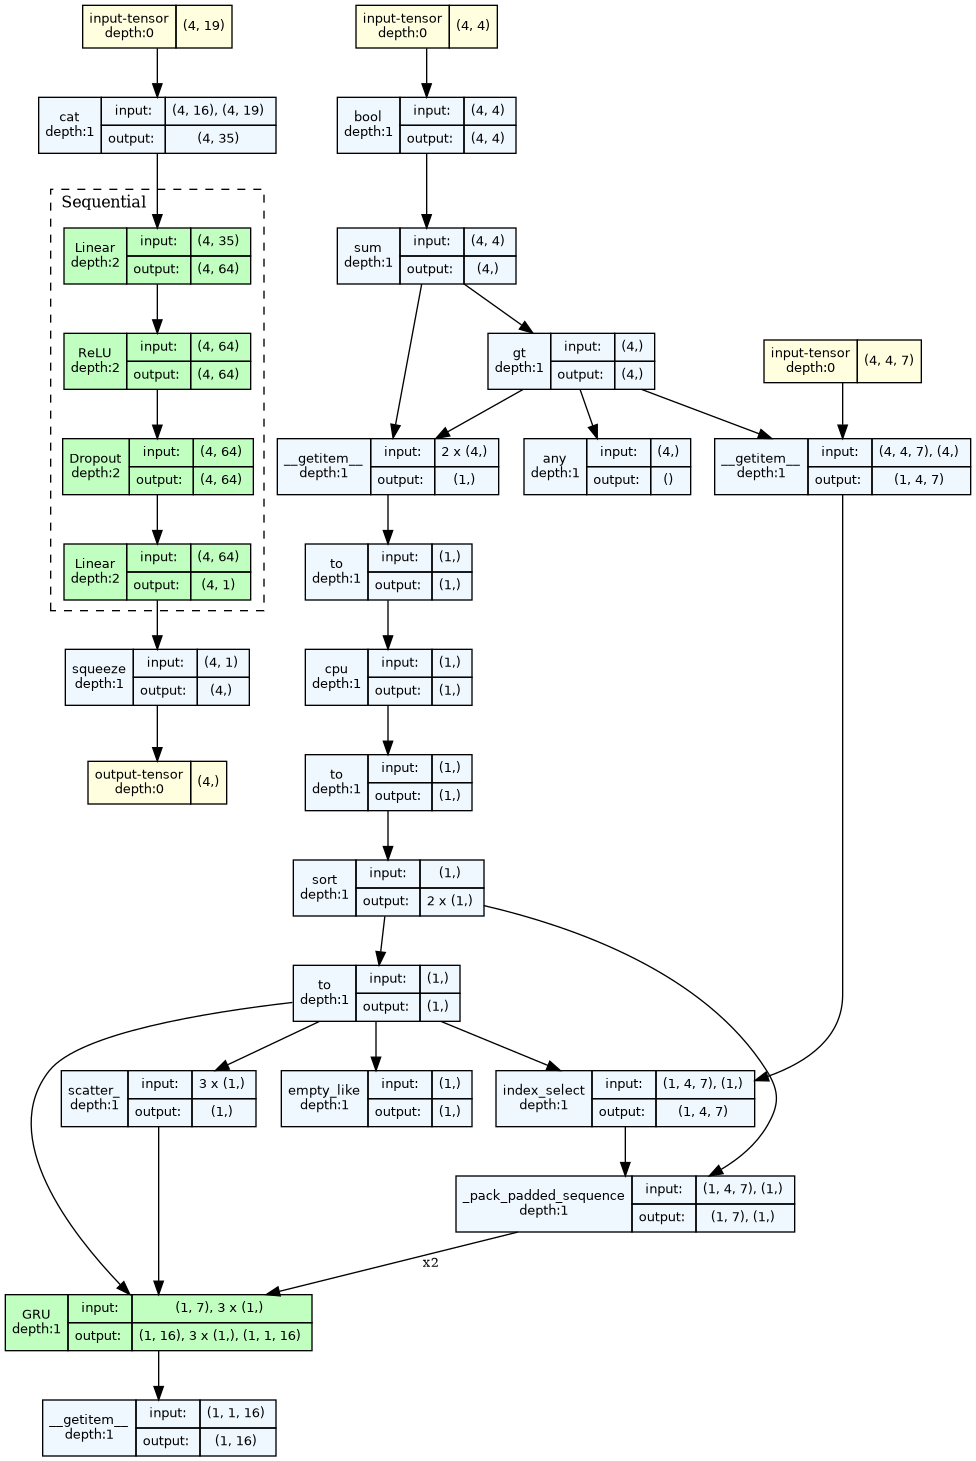

In [22]:
import os
from IPython.display import Image, SVG, display
if os.path.exists(display_path) and display_path.endswith(".png"):
    display(Image(display_path))
else:
    print("Graph file not found (check previous cell output).")
